In [1]:
import os
from pathlib import Path
import torch
import json
from datasets import load_dataset
import dotenv
from transformers import AutoTokenizer
from transformer_lens.utils import tokenize_and_concatenate
import tqdm
import torch
import matplotlib.pyplot as plt
import shutil
import torch.nn.functional as F

# Load our own imports, etc...
from sans_sae_lib.utils import plot_cosine_kernel, plot_all_nc2_top_pcs, plot_all_nc2_top_pcs_errs
from sans_sae_lib.schemas import ExtractedActivations, FlattenedExtractedActivations
from sans_sae_main import ResidAndLn2Comparer

dotenv.load_dotenv()
assert "CUDA_VISIBLE_DEVICES" in os.environ, "CUDA_VISIBLE_DEVICES is not set"
assert len(os.environ["CUDA_VISIBLE_DEVICES"].strip()) > 0, "CUDA_VISIBLE_DEVICES is empty"

print("="*50 + " [Loading Dataset] " + "="*50) # DEBUG
# dataset = load_dataset("openwebtext", split="train", trust_remote_code=True)
dataset = load_dataset("stas/openwebtext-10k", split="train", trust_remote_code=True) # Smaller version
tokenizer = AutoTokenizer.from_pretrained("gpt2")
token_dataset = tokenize_and_concatenate(
    dataset=dataset,  # type: ignore
    tokenizer=tokenizer,  # type: ignore
    streaming=True,
    # NOTE: all these have context 128
    max_length=128, #sae.cfg.context_size,
    add_bos_token=True, #sae.cfg.prepend_bos,
)
print("="*50 + " [Loading Model] " + "="*50) # DEBUG

/mnt/align3_drive/adrianoh/miniconda3/envs/llm-density/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


================================================== [Loading Dataset] ==================================================
================================================== [Loading Model] ==================================================


In [ ]:
# assert isinstance(token_dataset, torch.Tensor), f"token_dataset is not a torch.Tensor, it is a {type(token_dataset)}"
dataset_size = 800 # Seems kind of nonlinear??
tokens = token_dataset[:dataset_size]['tokens']
dataset_length = tokens.shape[0]
sequence_length = tokens.shape[1]
assert isinstance(tokens, torch.Tensor)
tokens = tokens.to("cuda")
tokens_is_special_token_mask = (tokens == tokenizer.bos_token_id) | (tokens == tokenizer.eos_token_id)
_ = tokens_is_special_token_mask.sum() .item()
# assert _ == tokens.shape[-1], f"Found {_} eos/bos tokens but have total {tokens.shape}" # will fail with a number slightly above it looks like?
tokens_is_special_token_mask = tokens_is_special_token_mask.flatten()
print(tokens_is_special_token_mask.shape)

torch.Size([64000])


In [3]:
from transformer_lens import HookedTransformer
from transformer_lens.hook_points import HookPoint
import functools as Ft
def collect_activations_hook(
        # Input
        activation: torch.Tensor,
        # HTF thing
        hook: HookPoint,
        # We will be saving to a tensor
        activations_save_loc: torch.Tensor,
         # Pass these below for sanity t esting
        left: int,
        right: int,
        model_dim: int,
        seq_len: int,
        hook_idx: int,
    ):
    """
    A simple hook function to used in `collect_all_activations` to save a buncha activations.
    """
    # Sanity check activations
    assert activation.ndim == 3, f"activation.ndim = {activation.ndim}" # fmt: skip
    assert activation.shape[0] == right - left, f"activation.shape[0] = {activation.shape[0]}, right - left = {right - left}" # fmt: skip
    assert activation.shape[1] == seq_len, f"activation.shape[1] = {activation.shape[1]}, model_seq_size = {seq_len}" # fmt: skip
    assert activation.shape[2] == model_dim, f"activation.shape[2] = {activation.shape[2]}, model_dim = {model_dim}" # fmt: skip

    # Sanity check outputs
    assert activations_save_loc.ndim == 4
    assert 0 <= hook_idx < activations_save_loc.shape[0]
    assert 0 <= left < right <= activations_save_loc.shape[1]
    assert 0 <= activation.shape[1] == activations_save_loc.shape[2]
    assert 0 <= activation.shape[2] == activations_save_loc.shape[3]

    # Store SAE IO
    activations_save_loc[hook_idx, left:right, :, :] = activation.detach().cpu()
    return activation


model = HookedTransformer.from_pretrained("gpt2")
model = model.to("cuda")
model.eval()
layer = 6
sans = torch.rand(1).item() * 9999999
d_model = 768
buffer = (torch.ones(*(list(tokens.shape) + [d_model])) * sans).cuda().unsqueeze(0)
assert torch.all(sans == buffer).item()
with torch.no_grad():
    model.run_with_hooks(tokens, stop_at_layer=layer+1, fwd_hooks=[
            (
                f"blocks.{layer}.hook_resid_pre",
                Ft.partial(
                    collect_activations_hook,
                    activations_save_loc=buffer,
                    left=0,
                    right=tokens.shape[0],
                    model_dim=d_model,
                    seq_len=tokens.shape[1],
                    hook_idx=0,
                )
            )
        ]
    ) # Halfway through ay lmao
assert not torch.any(sans == buffer).item()
activations = buffer.squeeze(0)
print(activations.shape)
activations = activations.reshape(-1, activations.shape[-1])
print(activations.shape)
assert activations.shape[:-1] == tokens_is_special_token_mask.shape
selection_mask = ~tokens_is_special_token_mask
activations = activations[selection_mask]
print(activations.shape)

Loaded pretrained model gpt2 into HookedTransformer
Moving model to device:  cuda
torch.Size([500, 128, 768])
torch.Size([64000, 768])
torch.Size([63437, 768])


In [4]:
import torch.nn.functional as F
from sae_lens import SAE
# Now we can use activations to do our EDA of the SAE features...
# def load_jbloom_gpt2_saes(self, sae_release: str = "gpt2-small-res-jb"):
#     self.saes = []
#     self.sae_cfg_dicts = []
#     self.sae_sparsities = []
#     for layer in range(self.model.cfg.n_layers):
#         sae, cfg_dict, sparsity = SAE.from_pretrained(
#             release = sae_release,
#             sae_id = f"blocks.{layer}.hook_resid_pre",
#             device = self.device
#         )
#         sae.eval()
#         self.saes.append(sae)
#         self.sae_cfg_dicts.append(cfg_dict)
#         self.sae_sparsities.append(sparsity)
sae, _, _ = SAE.from_pretrained(
    release = "gpt2-small-res-jb",
    # NOTE: it looks like `layer` is the best index here....
    sae_id = f"blocks.{layer}.hook_resid_pre",
    device = "cuda"
)
sae.eval()
decoded = sae(activations)
mse = F.mse_loss(decoded, activations)
percent_norm_error = ((decoded - activations).norm(dim=-1) / activations.norm(dim=-1)).mean()
# NOTE we are doing PER neuron here... not sure if that's the best? just wanna make sure it's not super high tbh
# TODO(Adriano) this FVU seems really bad but norm error is not thatttt bad???
# NOTE above it looks like I'm probably doing this right so eh...
fvu = ((decoded-activations).pow(2) / (activations - activations.mean(dim=0, keepdim=True)).pow(2)).mean()
fvu_norm = ((decoded-activations).pow(2).sum(dim=-1) / (activations - activations.mean(dim=0, keepdim=True)).pow(2).sum(dim=-1)).mean()
print(f"mse={mse.item()}")
print(f"(mean) percent_norm_error={percent_norm_error.item()}")
print(f"(mean) fvu={fvu.item()}")
print(f"(mean) fvu_norm={fvu_norm.item()}") # A lot better huh wth?? is this a convexity thing?

mse=0.5270455479621887
(mean) percent_norm_error=0.2461625635623932
(mean) fvu=inf
(mean) fvu_norm=0.12267804145812988


/mnt/align3_drive/adrianoh/miniconda3/envs/llm-density/lib/python3.12/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


In [5]:
# SAE latents importantly have the same shape as the activations
latents = sae.encode(activations)
assert latents.shape[0] == activations.shape[0]
d_latent = latents.shape[-1]
print(f"d_latent={d_latent}")

d_latent=24576


n_dead=1555860246, n_tot=1559027712, n_dead/n_tot=0.997968316078186


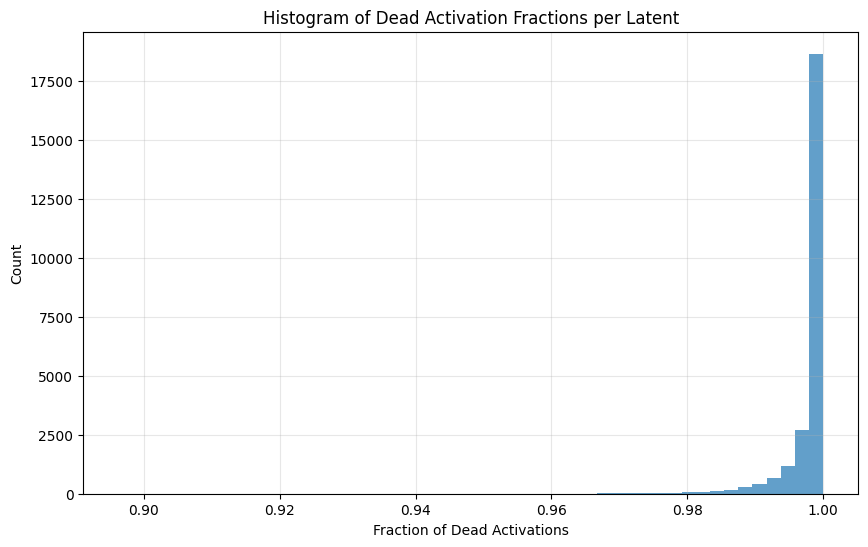

{
    "max": 1.0,
    "min": 0.8962277770042419,
    "mean": 0.9979683756828308,
    "median": 0.9994640350341797,
    "std": 0.004181208088994026,
    "25th percentile": 0.9980453252792358,
    "75th percentile": 0.9997793436050415
}


In [6]:
import json
assert latents.min() >= 0.0
n_dead = (latents == 0.0).sum()
n_tot = latents.numel()
# NOTE most are dead! this is basically what we want right
print(f"n_dead={n_dead}, n_tot={n_tot}, n_dead/n_tot={n_dead/n_tot}")
assert n_dead > 0
n_dead_per_latent = (latents == 0.0).sum(dim=0)
n_tot_per_latent = latents.shape[0]
frac_dead_per_latent = n_dead_per_latent / n_tot_per_latent

# Plot histogram of fraction of dead activations per latent
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
plt.hist(frac_dead_per_latent.cpu().numpy(), bins=50, alpha=0.7)
plt.xlabel('Fraction of Dead Activations')
plt.ylabel('Count')
plt.title('Histogram of Dead Activation Fractions per Latent')
plt.grid(alpha=0.3)
plt.show()

# Calculate and print statistics
# NOTE there seem to be no high frequency features??? All seem to be usually dead...
stats = {
    'max': frac_dead_per_latent.max().item(),
    'min': frac_dead_per_latent.min().item(),
    'mean': frac_dead_per_latent.mean().item(),
    'median': frac_dead_per_latent.median().item(),
    'std': frac_dead_per_latent.std().item(),
    '25th percentile': frac_dead_per_latent.quantile(0.25).item(),
    '75th percentile': frac_dead_per_latent.quantile(0.75).item(),
}
print(json.dumps(stats, indent=4))


latents_means[:10]: tensor([ 0.9649,  4.7596,  4.7715, 14.5048, 10.4443,  0.5668,  2.8335,  2.1937,
         8.5787, 13.5473], device='cuda:0', grad_fn=<SliceBackward0>)
latents_stdevs[:10]: tensor([4.5872e-01, 1.1026e+02, 7.2563e+00, 1.4055e+02, 3.2301e+02, 2.6185e-01,
        2.1278e+00, 6.5993e+00, 1.6610e+02, 1.4223e+02], device='cuda:0',
       grad_fn=<SliceBackward0>)


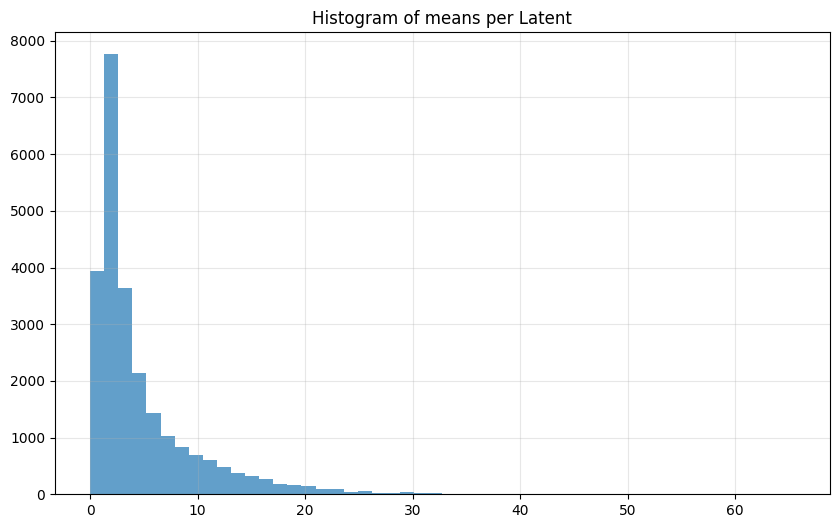

Statistics for latents means (not nan):
{
    "max": 65.53673553466797,
    "min": 0.0005791336297988892,
    "mean": 4.890209674835205,
    "median": 2.7624354362487793,
    "std": 5.350611209869385,
    "25th percentile": 1.624043345451355,
    "75th percentile": 6.042233467102051
}


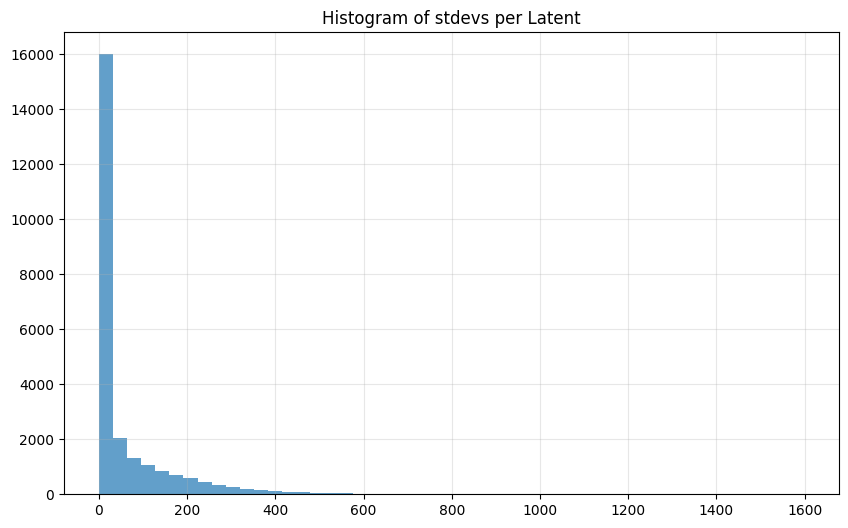

Statistics for latents stdevs (not nan):
{
    "max": 1597.445556640625,
    "min": 0.0,
    "mean": 59.85595703125,
    "median": 9.753252029418945,
    "std": 105.35706329345703,
    "25th percentile": 2.5495975017547607,
    "75th percentile": 71.74505615234375
}


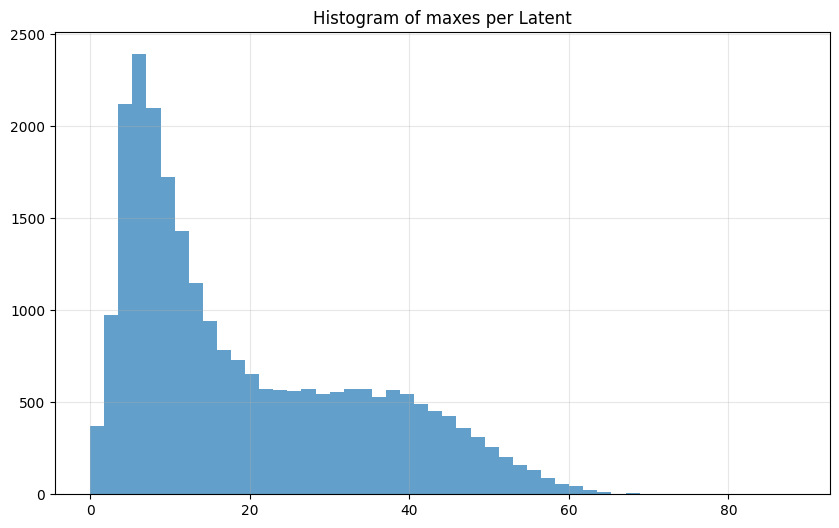

Statistics for latents maxes (not nan):
{
    "max": 88.28911590576172,
    "min": 0.0,
    "mean": 19.61837387084961,
    "median": 14.187202453613281,
    "std": 14.909034729003906,
    "25th percentile": 7.292969703674316,
    "75th percentile": 30.758350372314453
}


In [7]:
# Let's understand the optimal location to binarize (zero or distortion minimizer: mean)
# NOTE we should do this CONDITIONING on the case where the we assume the latents are non-zero
latents_n_zero = (latents != 0).sum(dim=0)
latents_means = latents.sum(dim=0) / latents_n_zero
# 2nd moment - exp sq.
latents_stdevs = (latents.pow(2).sum(dim=0) / latents_n_zero) - latents_means.pow(2)
print("latents_means[:10]:", latents_means[:10])
print("latents_stdevs[:10]:", latents_stdevs[:10])
latents_maxes = latents.max(dim=0).values
# latents_mins = latents.min(dim=0).values # eh ignore mins for now??
# print(latents_means.shape)
for arr, arr_name in zip(
    [
        latents_means,
        latents_stdevs,
        latents_maxes,
        # latents_mins
    ],
    [
        "means",
        "stdevs",
        "maxes",
        # "mins"
    ]
):
    # Plot histogram of latent means
    plt.figure(figsize=(10, 6))
    plt.hist(arr.detach().cpu().numpy(), bins=50, alpha=0.7)
    plt.title(f'Histogram of {arr_name} per Latent')
    plt.grid(alpha=0.3)
    plt.show()

    # Calculate and print statistics for latent means
    latent_mean_stats = {
        'max': arr[~arr.isnan()].max().item(),
        'min': arr[~arr.isnan()].min().item(),
        'mean': arr[~arr.isnan()].mean().item(),
        'median': arr[~arr.isnan()].median().item(),
        'std': arr[~arr.isnan()].std().item(),
        '25th percentile': torch.quantile(arr[~arr.isnan()], 0.25).item(),
        '75th percentile': torch.quantile(arr[~arr.isnan()], 0.75).item(),
    }
    print(f"Statistics for latents {arr_name} (not nan):")
    print(json.dumps(latent_mean_stats, indent=4))


In [8]:

# Let's look at the top K lowest variance (when non-zero) latents
K = 100
top_k_latents = latents_stdevs.argsort()[:K]
top_k_latents_stdevs = latents_stdevs[top_k_latents]
top_k_latents_means = latents_means[top_k_latents]

print("top_k_latents:", top_k_latents)
print("top_k_latents_stdevs:", top_k_latents_stdevs)
print("top_k_latents_means:", top_k_latents_means)


top_k_latents: tensor([   89,   202,   315,   566,   633,   935,   961,   980,   993,  1372,
         1852,  1932,  2013,  2218,  2467,  2469,  3007,  3032,  3299,  3442,
         3576,  3608,  3708,  3985,  4589,  4605,  5102,  5678,  5762,  5909,
         5956,  6014,  6181,  7231,  7368,  7487,  7627,  7659,  7852,  7868,
         7892,  8002,  8367,  8370,  8549,  9408,  9677,  9738, 10266, 10339,
        10380, 10613, 10645, 10971, 11090, 11502, 11649, 11692, 11766, 11968,
        12543, 12645, 12655, 12675, 12741, 12954, 13440, 13879, 14027, 14108,
        14477, 15245, 15341, 15609, 15890, 15907, 16194, 16651, 16729, 16918,
        17850, 17856, 17979, 18610, 18615, 18749, 19139, 19159, 19453, 19458,
        19805, 19917, 19974, 20158, 20279, 20374, 20720, 20724, 21034, 21245],
       device='cuda:0')
top_k_latents_stdevs: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [9]:
import pydantic
import gc
import tqdm
from typing import List
import torch.nn as nn
class BinarizedSAE(nn.Module):
    """
    The idea here is pretty simple: we will simply set the latents
    to the value we pass in here at the indices specified. This can be called
    with differnet indices to see the impact of binarizing multiple latents
    at once or every one individually.
    """
    def __init__(
            self,
            sae: SAE,
            binarize_indices: torch.Tensor,
            binarize_value: torch.Tensor,
        ):
        super().__init__()
        self.sae = sae
        self.binarize_indices = binarize_indices
        self.binarize_value = binarize_value
        assert self.binarize_indices.shape == self.binarize_value.shape

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.ndim == 2 or x.ndim == 3
        latents = self.sae.encode(x)
        assert latents.shape[0] == x.shape[0]
        assert latents.ndim == x.ndim
        # NOTE: you can use empty k to simulate no binarization
        if self.binarize_indices.numel() > 0:
            if x.ndim == 2:
                is_nonzero = ~(latents[:, self.binarize_indices] == 0)
                insertion = is_nonzero * self.binarize_value
                latents[:, self.binarize_indices] = insertion
            else:
                is_nonzero = ~(latents[:, :, self.binarize_indices] == 0)
                insertion = is_nonzero * self.binarize_value
                latents[:, :, self.binarize_indices] = insertion
        return self.sae.decode(latents)


# top_k_binarized_sae = BinarizedSAE(sae, top_k_latents, top_k_latents_means)
# top_k_binarized_sae.eval()

class ReconsttructionMetricsSingle(pydantic.BaseModel):
    fvu: float
    fvu_norm: float
    mse: float
    percent_norm_error: float
    loss: float
class ReconsttructionMetricsSweep(pydantic.BaseModel):
    fvu: List[float]
    fvu_norm: List[float]
    mse: List[float]
    percent_norm_error: List[float]
    loss: List[float]

def get_tl_loss(
    model: HookedTransformer,
    autoencoder: nn.Module,
    tokens: torch.Tensor,
    hook_point: str,
) -> float:
    def replace_hook_point(activations: torch.Tensor, hook: HookPoint) -> torch.Tensor:
        assert activations.ndim == 3, f"activations.shape={activations.shape}"
        decoded = autoencoder(activations) if autoencoder is not None else activations
        assert decoded.shape == activations.shape
        return decoded # Replace the activations
    with torch.no_grad():
        return model.run_with_hooks(
            tokens,
            fwd_hooks=[(hook_point, replace_hook_point)],
            return_type="loss"
        ).detach().item() # NOTE: detach seemingly is necessary to avoid memory leak?!
# print("Testing get_tl_loss") # DEBUG
# og_loss = get_tl_loss(model, sae, tokens, f"blocks.{layer}.hook_resid_pre")
# print(f"og_loss={og_loss}")

def evaluate_autoencoder_reconstruction(
    autoencoder: nn.Module,
    activations: torch.Tensor,
    tokens: torch.Tensor,
    hook_point: str,
    printout: bool = False,
) -> ReconsttructionMetricsSingle:
    """
    Just generalizes the code above to basically evaluate the SAE reconstruction error
    via various metrics to tell if the binarized SAE is OBVIOUSLY worse than the non-binarized
    version.

    NOTE: use autoencoder None to just use the activations directly
    """
    assert activations.ndim == 2
    decoded = autoencoder(activations) if autoencoder is not None else activations
    assert decoded.shape == activations.shape
    mse = F.mse_loss(decoded, activations)
    percent_norm_error = ((decoded - activations).norm(dim=-1) / activations.norm(dim=-1)).mean()
    # NOTE we are doing PER neuron here... not sure if that's the best? just wanna make sure it's not super high tbh
    # TODO(Adriano) this FVU seems really bad but norm error is not thatttt bad???
    # NOTE above it looks like I'm probably doing this right so eh...
    fvu = ((decoded-activations).pow(2) / (activations - activations.mean(dim=0, keepdim=True)).pow(2)).mean()
    fvu_norm = ((decoded-activations).pow(2).sum(dim=-1) / (activations - activations.mean(dim=0, keepdim=True)).pow(2).sum(dim=-1)).mean()
    # Final loss is NLL of the correct token prediction
    with torch.no_grad():
        assert decoded.shape == activations.shape
        loss = get_tl_loss(model, autoencoder, tokens, hook_point)
    if printout:
        print(f"mse={mse.item()}")
        print(f"(mean) percent_norm_error={percent_norm_error.item()}")
        print(f"(mean) fvu={fvu.item()}")
        print(f"(mean) fvu_norm={fvu_norm.item()}") # A lot better huh wth?? is this a convexity thing?
    return ReconsttructionMetricsSingle(
        fvu=fvu.item(),
        fvu_norm=fvu_norm.item(),
        mse=mse.item(),
        percent_norm_error=percent_norm_error.item(),
        loss=loss,
    )

def sweep_first_ks(
    # Write INTO here
    top_k_indices: torch.Tensor,
    # Write THIS value
    top_k_values: torch.Tensor,
    # Test on these activations to get metrics
    activations: torch.Tensor,
    tokens: torch.Tensor,
    hook_point: str,
) -> ReconsttructionMetricsSweep:
    activations = activations.detach() # ??
    fvus, fvu_norms, mses, percent_norm_errors, losses = [], [], [], [], []
    for k in tqdm.trange(-1, top_k_indices.shape[0] + 1):
        binarized_sae = BinarizedSAE(sae, top_k_indices[:k], top_k_values[:k]) if k >= 0 else None
        metrics = evaluate_autoencoder_reconstruction(binarized_sae, activations, tokens, hook_point)
        # Append to our lists
        fvus.append(metrics.fvu)
        fvu_norms.append(metrics.fvu_norm)
        mses.append(metrics.mse)
        percent_norm_errors.append(metrics.percent_norm_error)
        losses.append(metrics.loss)
        # ...
        torch.cuda.empty_cache()
        gc.collect()
    # Return our metrics
    return ReconsttructionMetricsSweep(
        fvu=fvus,
        fvu_norm=fvu_norms,
        mse=mses,
        percent_norm_error=percent_norm_errors,
        loss=losses,
    )


gc.collect()
torch.cuda.empty_cache()
# evaluate_autoencoder_reconstruction(sae, activations)
# evaluate_autoencoder_reconstruction(top_k_binarized_sae, activations)
sweeped_first_K = sweep_first_ks(
    top_k_latents,
    top_k_latents_means,
    activations,
    tokens,
    hook_point=f"blocks.{layer}.hook_resid_pre"
)

100%|██████████| 102/102 [02:11<00:00,  1.28s/it]


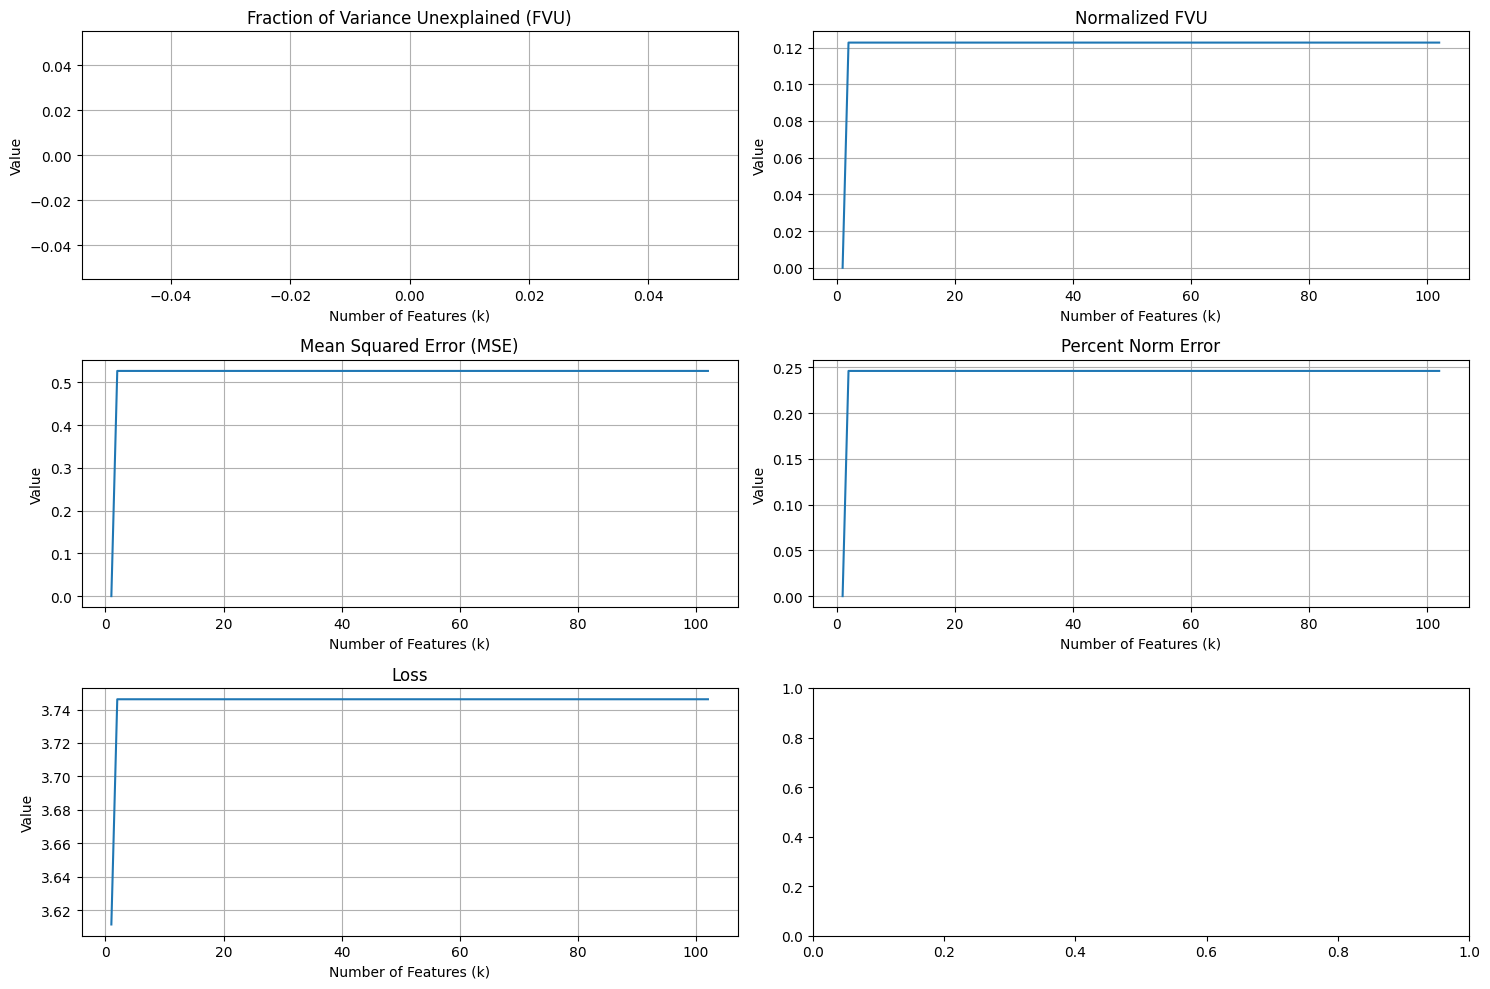

In [10]:
import matplotlib.pyplot as plt

# Create a 3x2 grid of plots
fig, axs = plt.subplots(3, 2, figsize=(15, 10))

# Flatten the axes array for easier iteration
axs = axs.flatten()

# Plot data with appropriate titles and labels
metrics = [
    (sweeped_first_K.fvu, "Fraction of Variance Unexplained (FVU)"),
    (sweeped_first_K.fvu_norm, "Normalized FVU"),
    (sweeped_first_K.mse, "Mean Squared Error (MSE)"),
    (sweeped_first_K.percent_norm_error, "Percent Norm Error"),
    (sweeped_first_K.loss, "Loss")
]

for i, (data, title) in enumerate(metrics):
    # Create x-axis values (1 to k)
    x = list(range(1, len(data) + 1))
    
    # Plot the data
    axs[i].plot(x, data)
    axs[i].set_title(title)
    axs[i].set_xlabel("Number of Features (k)")
    axs[i].set_ylabel("Value")
    axs[i].grid(True)

plt.tight_layout()
plt.show()
